## Linear Regression

### Added snippet used as a reference for all models

This model is based on the TuringTutorial example [LinearRegression](https://github.com/TuringLang/TuringTutorials/blob/csp/linear/LinearRegression.ipynb) by Cameron Pfiffer.

Turing is powerful when applied to complex hierarchical models, but it can also be put to task at common statistical procedures, like linear regression. This tutorial covers how to implement a linear regression model in Turing.

We begin by importing all the necessary libraries.

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, GLM
gr(size=(500,500))

ProjDir = rel_path("..", "chapters", "00")
cd(ProjDir)

Import the dataset.

In [2]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [3]:
data = filter(row -> row[:age] >= 18, df)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


Show the first six rows of the dataset.

In [4]:
first(data, 6)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1


The next step is to get our data ready for testing. We'll split the mtcars dataset into two subsets, one for training our model and one for evaluating our model. Then, we separate the labels we want to learn (MPG, in this case) and standardize the datasets by subtracting each column's means and dividing by the standard deviation of that column.

The resulting data is not very familiar looking, but this standardization process helps the sampler converge far easier. We also create a function called unstandardize, which returns the standardized values to their original form. We will use this function later on when we make predictions.

Split our dataset 70%/30% into training/test sets.

In [5]:
train, test = MLDataUtils.splitobs(shuffleobs(data), at = 0.7);

┌ Warning: `view(adf, x)` will select all rows and columns `x` from `adf` in the future. Use `view(adf, x, :)` to select rows `x` and all columns from `adf` instead.
│   caller = datasubset at datapattern.jl:10 [inlined]
└ @ Core /Users/rob/.julia/dev/MLDataUtils/src/datapattern.jl:10
┌ Warning: `view(adf, x)` will select all rows and columns `x` from `adf` in the future. Use `view(adf, x, :)` to select rows `x` and all columns from `adf` instead.
│   caller = datasubset at datapattern.jl:10 [inlined]
└ @ Core /Users/rob/.julia/dev/MLDataUtils/src/datapattern.jl:10
┌ Warning: `view(adf, x)` will select all rows and columns `x` from `adf` in the future. Use `view(adf, x, :)` to select rows `x` and all columns from `adf` instead.
│   caller = ip:0x0
└ @ Core :-1


Save dataframe versions of our dataset.

In [6]:
train_cut = DataFrame(train)
test_cut = DataFrame(test)

┌ Warning: `sdf.col_ind` will create a view of `parent(sdf).col_ind` in the future. Use sdf[:, col_ind]` to get a freshly allocated vector.
│   caller = iterate at utils.jl:111 [inlined]
└ @ Core /Users/rob/.julia/packages/Tables/Icwxo/src/utils.jl:111
┌ Warning: `sdf.col_ind` will create a view of `parent(sdf).col_ind` in the future. Use sdf[:, col_ind]` to get a freshly allocated vector.
│   caller = iterate at utils.jl:111 [inlined]
└ @ Core /Users/rob/.julia/packages/Tables/Icwxo/src/utils.jl:111


,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,152.4,43.0629,29.0,0
2,148.59,37.5631,36.0,0
3,144.78,36.0322,73.0,0
4,161.925,50.2353,43.0,1
5,140.97,40.9367,85.6,0
6,154.94,47.2019,22.0,0
7,160.655,47.8823,41.0,1
8,148.59,37.9033,45.0,0
9,152.4,43.5448,63.0,0


Create our labels. These are the values we are trying to predict.

In [7]:
train_label = train[:, :height]
test_label = test[:, :height]

106-element Array{Union{Missing, Float64},1}:
 152.4  
 148.59 
 144.78 
 161.925
 140.97 
 154.94 
 160.655
 148.59 
 152.4  
 145.415
   ⋮    
 158.115
 156.21 
 157.48 
 147.955
 150.495
 163.195
 163.83 
 163.83 
 161.3  

Get the list of columns to keep.

In [8]:
remove_names = filter(x->!in(x, [:height, :age, :male]), names(data))

1-element Array{Symbol,1}:
 :weight

Filter the test and train sets.

In [9]:
train = Matrix(train[:, remove_names]);
test = Matrix(test[:, remove_names]);

A handy helper function to rescale our dataset.

In [10]:
function standardize(x)
    return (x .- mean(x, dims=1)) ./ std(x, dims=1), x
end

standardize (generic function with 1 method)

Another helper function to unstandardize our datasets.

In [11]:
function unstandardize(x, orig)
    return x .* std(orig, dims=1) .+ mean(orig, dims=1)
end

unstandardize (generic function with 1 method)

Standardize our dataset.

In [12]:
(train, train_orig) = standardize(train)
(test, test_orig) = standardize(test)
(train_label, train_l_orig) = standardize(train_label)
(test_label, test_l_orig) = standardize(test_label);

Design matrix

In [13]:
dmat = [ones(size(train, 1)) train]

246×2 Array{Float64,2}:
 1.0  -0.486542
 1.0  -0.842056
 1.0  -1.84715 
 1.0   0.558055
 1.0  -0.626992
 1.0  -0.179308
 1.0   1.76066 
 1.0   0.615113
 1.0  -0.837667
 1.0   0.575611
 ⋮             
 1.0   1.3437  
 1.0  -2.12366 
 1.0   0.358657
 1.0  -1.51797 
 1.0   0.90918 
 1.0  -1.15368 
 1.0   1.65093 
 1.0   0.645832
 1.0  -0.907892

Bayesian linear regression.

In [14]:
lrmodel = "
data {
  int N; //the number of observations
  int K; //the number of columns in the model matrix
  real y[N]; //the response
  matrix[N,K] X; //the model matrix
}
parameters {
  vector[K] beta; //the regression parameters
  real sigma; //the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred <- X*beta;
}
model {
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008

  y ~ normal(linpred,sigma);
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [15]:
stanmodel = Stanmodel(name="linear_regression",
  monitors = ["beta.1", "beta.2", "sigma"],
  model=lrmodel);
# Input data for cmdstan
lrdata = [
  Dict("N" => size(train, 1), "K" => size(dmat, 2), "y" => train_label, "X" => dmat)
];

=====> /Users/rob/.julia/dev/StatisticalRethinking/chapters/00


File /Users/rob/.julia/dev/StatisticalRethinking/chapters/00/tmp/linear_regression.stan will be updated.



Sample using cmdstan

In [16]:
rc, sim, cnames = stan(stanmodel, lrdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# Convert to a MCMCChain Chain object
cnames = ["intercept", "beta[1]", "sigma"]
chain = convert_a3d(sim, cnames, Val(:mcmcchain))



--- Translating Stan model to C++ code ---
bin/stanc  /Users/rob/.julia/dev/StatisticalRethinking/chapters/00/tmp/linear_regression.stan --o=/Users/rob/.julia/dev/StatisticalRethinking/chapters/00/tmp/linear_regression.hpp
Model name=linear_regression_model
Input file=/Users/rob/.julia/dev/StatisticalRethinking/chapters/00/tmp/linear_regression.stan
Output file=/Users/rob/.julia/dev/StatisticalRethinking/chapters/00/tmp/linear_regression.hpp

--- Linking C++ model ---
clang++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.66.0 -isystem stan/lib/stan_math/lib/sundials_3.1.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -DNO_FPRINTF_OUTPUT -pipe   src/cmdstan/main.cpp  -O3 -o /Users/rob/.julia/d

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[-0.0143759 0.767904 0.656658; -0.0127373 0.728171 0.676474; … ; 0.0378557 0.780046 0.635394; -0.0234546 0.734887 0.696631]

Union{Missing, Float64}[0.0340847 0.789502 0.677241; 0.00709755 0.711677 0.662691; … ; 0.122174 0.665894 0.662536; -0.104696 0.80951 0.713437]

Union{Missing, Float64}[-0.000731561 0.745084 0.618059; 0.0268561 0.740486 0.663295; … ; -0.0379744 0.75602 0.625569; 0.0202231 0.835048 0.714797]

Union{Missing, Float64}[-0.0681508 0.749266 0.692213; -0.0447883 0.711089 0.67034; … ; 0.0101949 0.727345 0.675807; -0.00351209 0.743137 0.674408]

Describe the chains.

In [17]:
describe(chain)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
               Mean          SD        Naive SE        MCSE      ESS
intercept -0.0004984485 0.042947821 0.00067906468 0.00068416101 1000
  beta[1]  0.7473582192 0.042390131 0.00067024682 0.00062664900 1000
    sigma  0.6684123475 0.030763033 0.00048640627 0.00048099113 1000

Quantiles:
              2.5%        25.0%        50.0%       75.0%       97.5%  
intercept -0.08692685 -0.027981875 -0.000151808 0.027812525 0.08177387
  beta[1]  0.66035365  0.718905000  0.746948500 0.775551250 0.83042450
    sigma  0.61256205  0.646901500  0.666731000 0.688294000 0.73191793



Perform multivariate OLS.

In [18]:
ols = lm(@formula(height ~ weight), train_cut)

┌ Warning: In the future eachcol will have names argument set to false by default
│   caller = evalcontrasts(::DataFrame, ::Dict{Any,Any}) at modelframe.jl:124
└ @ StatsModels /Users/rob/.julia/packages/StatsModels/AYB2E/src/modelframe.jl:124


StatsModels.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: height ~ 1 + weight

Coefficients:
             Estimate Std.Error t value Pr(>|t|)
(Intercept)   112.806   2.42399 46.5375   <1e-99
weight       0.930011 0.0528806  17.587   <1e-44


Store our predictions in the original dataframe.

In [19]:
train_cut.OLSPrediction = predict(ols);
test_cut.OLSPrediction = predict(ols, test_cut);

┌ Warning: In the future eachcol will have names argument set to false by default
│   caller = evalcontrasts(::DataFrame, ::Dict{Symbol,StatsModels.ContrastsMatrix}) at modelframe.jl:124
└ @ StatsModels /Users/rob/.julia/packages/StatsModels/AYB2E/src/modelframe.jl:124


Make a prediction given an input vector.

In [20]:
function prediction(chain, x)
    α = chain[:, 1, :].value
    β = [chain[:, i, :].value for i in 2:2]
    return  mean(α) .+ x * mean.(β)
end

prediction (generic function with 1 method)

Calculate the predictions for the training and testing sets.

In [21]:
train_cut.BayesPredictions = unstandardize(prediction(chain, train), train_l_orig);
test_cut.BayesPredictions = unstandardize(prediction(chain, test), test_l_orig);
#train_cut.BayesPredictions = prediction(chain, train);
#test_cut.BayesPredictions = prediction(chain, test);

Show the first side rows of the modified dataframe.

In [22]:
remove_names = filter(x->!in(x, [:age, :male]), names(test_cut))
test_cut = test_cut[remove_names]
first(test_cut, 6) |> display

bayes_loss1 = sum((train_cut.BayesPredictions - train_cut.height).^2)
ols_loss1 = sum((train_cut.OLSPrediction - train_cut.height).^2)

bayes_loss2 = sum((test_cut.BayesPredictions - test_cut.height).^2)
ols_loss2 = sum((test_cut.OLSPrediction - test_cut.height).^2)

println("\nTraining set:")
println("  Bayes loss: $bayes_loss1")
println("  OLS loss: $ols_loss1")

println("Test set:")
println("  Bayes loss: $bayes_loss2")
println("  OLS loss: $ols_loss2")


Training set:
  Bayes loss: 6974.240158674628
  OLS loss: 6974.234668517081
Test set:
  Bayes loss: 2056.6413962156284
  OLS loss: 2090.593999919282


Plot the chains.

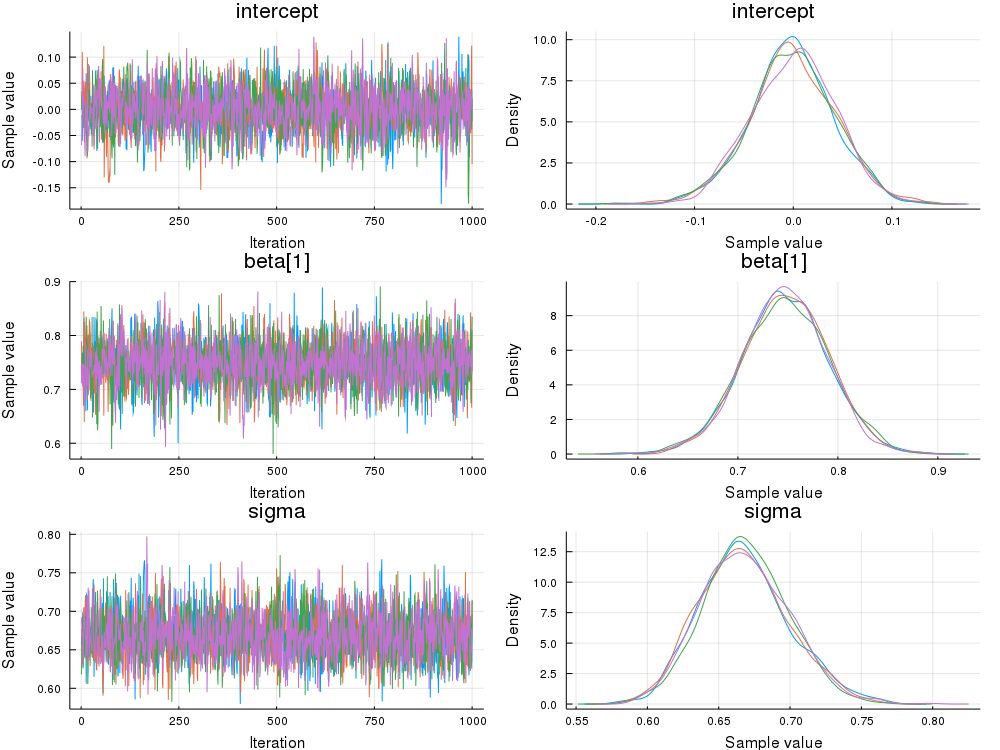

In [23]:
plot(chain)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*